In [15]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))
sys.path.append(str(Path.cwd().parent / 'data' / 'europe_day_ahead_prices'))

In [62]:

er = pd.read_csv(
    Path.cwd().parent /
    'data' /
    'europe_day_ahead_prices' /
    'ECB Data Portal_20241012123932.csv',
    index_col=0,
    parse_dates=True
)
er.rename(columns={'UK pound sterling/Euro (EXR.D.GBP.EUR.SP00.A)': 'rate'}, inplace=True)
er = (
    er.reindex(
        pd.date_range(er.index.min(), er.index.max(), freq='D'),
        fill_value=np.nan)
    .interpolate()
    ['rate']
)

er

C:\Users\lukas\AppData\Local\Temp\ipykernel_20332\3796530139.py:16: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  .interpolate()


1999-01-04    0.71110
1999-01-05    0.71220
1999-01-06    0.70760
1999-01-07    0.70585
1999-01-08    0.70940
               ...   
2024-10-07    0.83918
2024-10-08    0.83778
2024-10-09    0.83740
2024-10-10    0.83686
2024-10-11    0.83705
Freq: D, Name: rate, Length: 9413, dtype: float64

In [63]:
er.loc['2022']

2022-01-01    0.840637
2022-01-02    0.840993
2022-01-03    0.841350
2022-01-04    0.836180
2022-01-05    0.835460
                ...   
2022-12-27    0.883330
2022-12-28    0.880580
2022-12-29    0.885490
2022-12-30    0.886930
2022-12-31    0.886720
Freq: D, Name: rate, Length: 365, dtype: float64

In [76]:
def preprocess_df(df):
    df = df[df['Datetime (UTC)'] >= '2022-01-01']
    df = df[['Datetime (UTC)', 'Country', 'Price (EUR/MWhe)']]

    df['Price (GBP/MWhe)'] = df.apply(
        lambda row: row['Price (EUR/MWhe)'] * er.at[row['Datetime (UTC)'][:10]],
        axis=1,
    )

    df.rename(columns={'Price (GBP/MWhe)': df.Country.iloc[0]}, inplace=True)
    df.drop(columns=['Country', 'Price (EUR/MWhe)'], inplace=True)

    return df.set_index('Datetime (UTC)')



all_dfs = []
for country in ['Norway', 'Belgium', 'France', 'Germany', 'Netherlands', 'Ireland', 'Denmark']:

    all_dfs.append(
        preprocess_df(
            pd.read_csv(Path.cwd().parent / 'data' / 'europe_day_ahead_prices' / f'{country}.csv')
        )
    )

prices = pd.concat(all_dfs, axis=1)

In [78]:
prices.to_csv('europe_day_ahead_prices_GBP.csv', index=True)

In [1]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'bmus_prepared.csv',
    index_col=0,
)

In [17]:
bmus.index[bmus.index.str.startswith('EAD')]

Index([], dtype='object', name='NationalGridBmUnit')

In [7]:
inter_mapper = {
    'BritNed': ['IBG'],
    'IFA1': ['IFD', 'IFG'],
    'IFA2': ['I2D', 'I2G', 'ING'],
    'EastWest': ['IID'],
    'Moyle': ['IMD'],
    'Viking': ['IVD', 'IVG'],
    'ElecLink': ['IED', 'IEG', 'ILD', 'ILG'],
    'NSL': ['ISD', 'ISG'],
}

In [40]:
# source: https://www.ofgem.gov.uk/energy-policy-and-regulation/policy-and-regulatory-programmes/interconnectors
intercon_capacities = {
    'IFA1': 2000, # MW
    'Moyle': 500, # MW
    'BritNed': 1000, # MW
    'IFA2': 1000, # MW
    'EastWest': 500, # MW (also EWIC)
    'Viking': 1400, # MW,
    'ElecLink': 1000, # MW
    'NSL': 1400, # MW
    'Nemo': 1000, # MW
}

In [26]:
day = '2023-09-01'

path = Path.cwd().parent / 'data' / 'base' / day

pn = pd.read_csv(path / 'physical_notifications.csv', index_col=0, parse_dates=True)
mel = pd.read_csv(path / 'maximum_export_limits.csv', index_col=0, parse_dates=True)

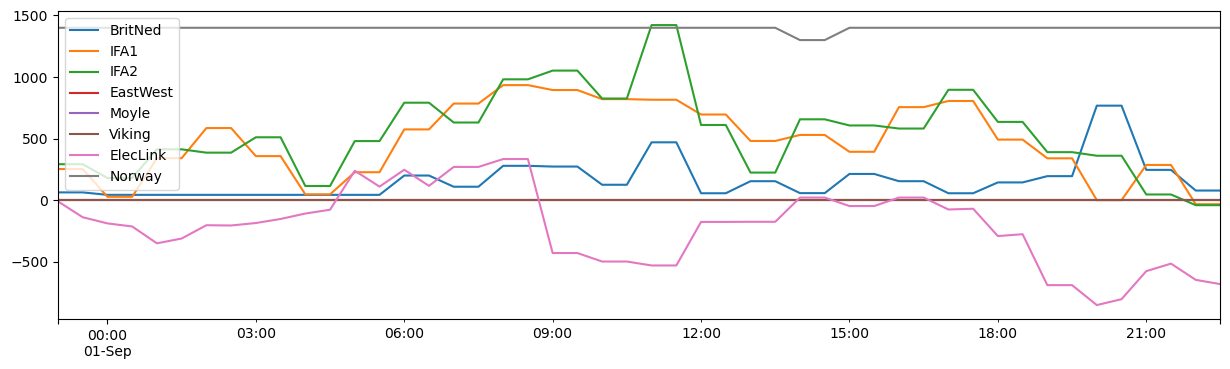

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 4))

# pn['IND-ALIP1'
# pn[pn.columns[pn.columns.str.contains('NEMO')]]
for ic, bmus in inter_mapper.items():
    pn[pn.columns[pn.columns.str.contains('|'.join(bmus))]].sum(axis=1).plot(ax=ax, label=ic)

ax.legend()
plt.show()

<Axes: >

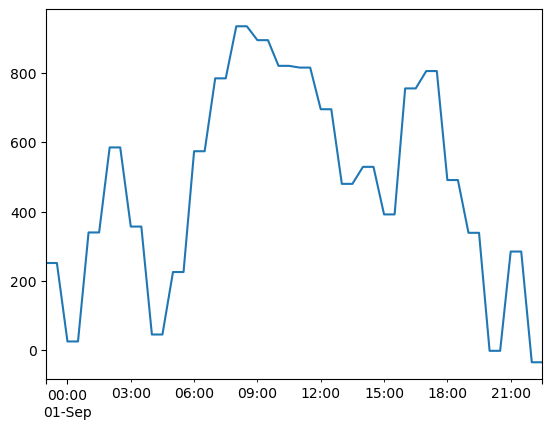

In [41]:
def get_interconnector_flow(pn, name):

    flow = (
        pn[
            pn.columns[
                pn.columns.str.contains('|'.join(
                    inter_mapper[name]
                ))
                ]]
            .sum(axis=1)
    )
    assert (flow.abs() <= intercon_capacities[name]).all()
    return flow

# pn[pn.columns[pn.columns.str.contains('NEMO')]].plot()

get_interconnector_flow(pn, 'IFA1').plot()

In [2]:
import sys
import pandas as pd
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))

from _tokens import ENTSOE_API_KEY

In [ ]:
from entsoe import EntsoePandasClient

client = EntsoePandasClient(api_key=ENTSOE_API_KEY)

# start = pd.Timestamp('20240202', tz='Europe/Brussels')
# end = pd.Timestamp('20240203', tz='Europe/Brussels')
start = pd.Timestamp('20221212', tz='utc')
end = pd.Timestamp('20221217', tz='utc')

country_code_from = 'BE'
country_code_to = 'GB'

nemo_BEGB = client.query_crossborder_flows(
    country_code_from,
    country_code_to,
    start=start,
    end=end,
    )
nemo_GBBE = client.query_crossborder_flows(
    country_code_to,
    country_code_from,
    start=start,
    end=end,
    )

<Axes: >

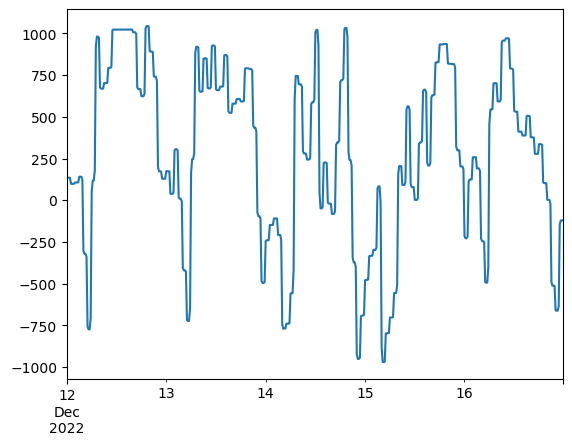

In [12]:
(nemo_BEGB - nemo_GBBE).plot()

In [ ]:
import sys
sys.path.append(str(Path.cwd().parent / 'scripts'))

from _constants import build_sp_register

date_range = build_sp_register('2022-12-12').index

In [45]:
client = EntsoePandasClient(api_key=ENTSOE_API_KEY, retry_delay=60)

nemo_BEGB = client.query_crossborder_flows(
    'BE', 'GB',
    start=date_range[0] - pd.Timedelta('60min'),
    end=date_range[-1] + pd.Timedelta('60min'),
    )

<Axes: >

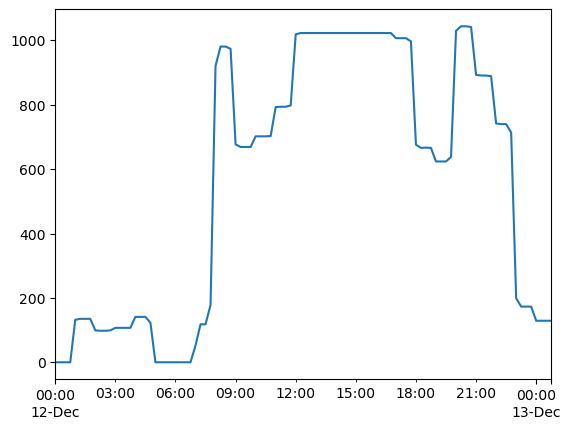

In [46]:
nemo_BEGB.plot()

In [47]:
nemo_GBBE = client.query_crossborder_flows(
    'GB', 'BE',
    start=date_range[0] - pd.Timedelta('60min'),
    end=date_range[-1] + pd.Timedelta('60min'),
    )

nemo_flow = (nemo_BEGB - nemo_GBBE).resample('30min').mean()

In [ ]:
if nemo_flow.index.tz is None:
    nemo_flow.index = nemo_flow.index.tz_localize(date_range.tz)
else:
    nemo_flow.index = nemo_flow.index.tz_convert(date_range.tz)

nemo_flow = nemo_flow.loc[date_range]

assert nemo_flow.index.equals(date_range)

In [49]:
print(date_range[0] - pd.Timedelta('60min'), date_range[-1] + pd.Timedelta('60min'))

2022-12-11 23:00:00+00:00 2022-12-13 00:30:00+00:00


In [50]:
nemo_flow

2022-12-12 00:00:00+00:00     133.5
2022-12-12 00:30:00+00:00     135.0
2022-12-12 01:00:00+00:00      98.5
2022-12-12 01:30:00+00:00      98.5
2022-12-12 02:00:00+00:00     107.0
2022-12-12 02:30:00+00:00     107.0
2022-12-12 03:00:00+00:00     141.0
2022-12-12 03:30:00+00:00     132.0
2022-12-12 04:00:00+00:00    -313.0
2022-12-12 04:30:00+00:00    -330.0
2022-12-12 05:00:00+00:00    -766.0
2022-12-12 05:30:00+00:00    -740.5
2022-12-12 06:00:00+00:00      85.0
2022-12-12 06:30:00+00:00     148.0
2022-12-12 07:00:00+00:00     951.0
2022-12-12 07:30:00+00:00     977.5
2022-12-12 08:00:00+00:00     673.0
2022-12-12 08:30:00+00:00     669.0
2022-12-12 09:00:00+00:00     702.0
2022-12-12 09:30:00+00:00     702.5
2022-12-12 10:00:00+00:00     793.5
2022-12-12 10:30:00+00:00     796.0
2022-12-12 11:00:00+00:00    1021.0
2022-12-12 11:30:00+00:00    1023.0
2022-12-12 12:00:00+00:00    1023.0
2022-12-12 12:30:00+00:00    1023.0
2022-12-12 13:00:00+00:00    1023.0
2022-12-12 13:30:00+00:00   